<a href="https://colab.research.google.com/github/mahsoutoura/ExpressoChurnPredictionChallenge/blob/main/Copy_of_ExpressoChurnPredictionChallenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Expresso Churn Prediction Challenge**

# Importing libraries


In [1]:
!pip install plotly
!pip install catboost
!pip install xgboost

     |████████████████████████████████| 76.3 MB 89 kB/s 


In [2]:
import pandas as pd
import numpy as np
import datetime as dt
from tqdm.notebook import tqdm_notebook
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway
from scipy.stats import chi2_contingency
from random import randint
%matplotlib inline

import plotly.offline as pyoff
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

from sklearn.metrics import accuracy_score,confusion_matrix,recall_score,precision_recall_curve, f1_score, classification_report, roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit

from sklearn.ensemble import StackingClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression

from sklearn.feature_selection import VarianceThreshold

import warnings
warnings.filterwarnings('ignore')
from collections import Counter 

import random
random.seed(123)

 # Reading the data into python¶


In [3]:
train = pd.read_csv('train-2.csv')

In [4]:
train.shape

(800000, 19)

In [5]:
test = pd.read_csv('Test.csv')
test.shape

(380127, 18)

In [6]:
ss = pd.read_csv('SampleSubmission.csv')
ss.head()

,user_id,CHURN
0,00001dbe00e56fc4b1c1b65dda63de2a5ece55f9,0
1,000055d41c8a62052dd426592e8a4a3342bf565d,0
2,000081dd3245e6869a4a9c574c7050e7bb84c2c8,0
3,0000b76d2145d9445d9ff6b65c9ebc4196c89337,0
4,0000bae5480628cf8fe51ad84bcb39772fc79224,0


# Combine train and test 

In [7]:
# Combine train and test set
ntrain = train.shape[0]

all_data = pd.concat((train, test)).reset_index(drop=True)
print(f'The shape of the combined dataframe is: {all_data.shape}')

The shape of the combined dataframe is: (1180127, 19)


#### Removing duplicate rows if any

In [8]:
print('Shape of the training set before deleting duplicate values:', all_data.shape)

all_data = all_data.drop_duplicates()
print('Shape After deleting duplicate values:', all_data.shape)
all_data.drop(['user_id', 'MRG',], 1, inplace = True)

Shape of the training set before deleting duplicate values: (1180127, 19)
Shape After deleting duplicate values: (1180127, 19)


In [9]:
all_data.head()

,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,REGULARITY,TOP_PACK,FREQ_TOP_PACK,CHURN
0,FATICK,K > 24 month,4250.0,15.0,4251.0,1417.0,17.0,4.0,388.0,46.0,1.0,1.0,2.0,54,On net 200F=Unlimited _call24H,8.0,0.0
1,NaN,I 18-21 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN,NaN,1.0
2,NaN,K > 24 month,3600.0,2.0,1020.0,340.0,2.0,NaN,90.0,46.0,7.0,NaN,NaN,17,On-net 1000F=10MilF;10d,1.0,0.0
3,DAKAR,K > 24 month,13500.0,15.0,13502.0,4501.0,18.0,43804.0,41.0,102.0,2.0,NaN,NaN,62,"Data:1000F=5GB,7d",11.0,0.0
4,DAKAR,K > 24 month,1000.0,1.0,985.0,328.0,1.0,NaN,39.0,24.0,NaN,NaN,NaN,11,Mixt 250F=Unlimited_call24H,2.0,0.0


# Data Exploration 

In [10]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1180127 entries, 0 to 1180126
Data columns (total 17 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   REGION          714919 non-null   object 
 1   TENURE          1180127 non-null  object 
 2   MONTANT         766285 non-null   float64
 3   FREQUENCE_RECH  766285 non-null   float64
 4   REVENUE         783268 non-null   float64
 5   ARPU_SEGMENT    783268 non-null   float64
 6   FREQUENCE       783268 non-null   float64
 7   DATA_VOLUME     599105 non-null   float64
 8   ON_NET          749430 non-null   float64
 9   ORANGE          690520 non-null   float64
 10  TIGO            474254 non-null   float64
 11  ZONE1           92903 non-null    float64
 12  ZONE2           74728 non-null    float64
 13  REGULARITY      1180127 non-null  int64  
 14  TOP_PACK        686566 non-null   object 
 15  FREQ_TOP_PACK   686566 non-null   float64
 16  CHURN           800000 non-null   fl

0.0    650093
1.0    149907
Name: CHURN, dtype: int64


Text(0.5, 0, 'Churn')

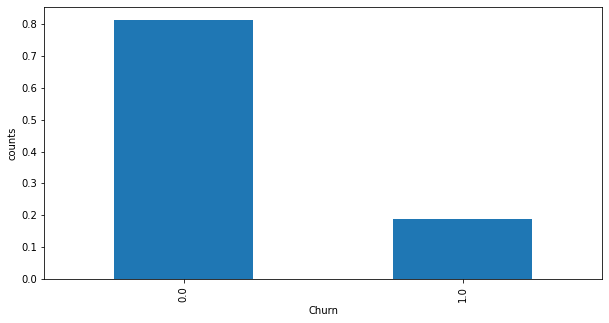

In [11]:
print(train['CHURN'].value_counts())
plt.figure(figsize=(10,5))
train['CHURN'].value_counts(normalize=True).plot(kind='bar')
plt.ylabel('counts')
plt.xlabel('Churn')

### Categorical features

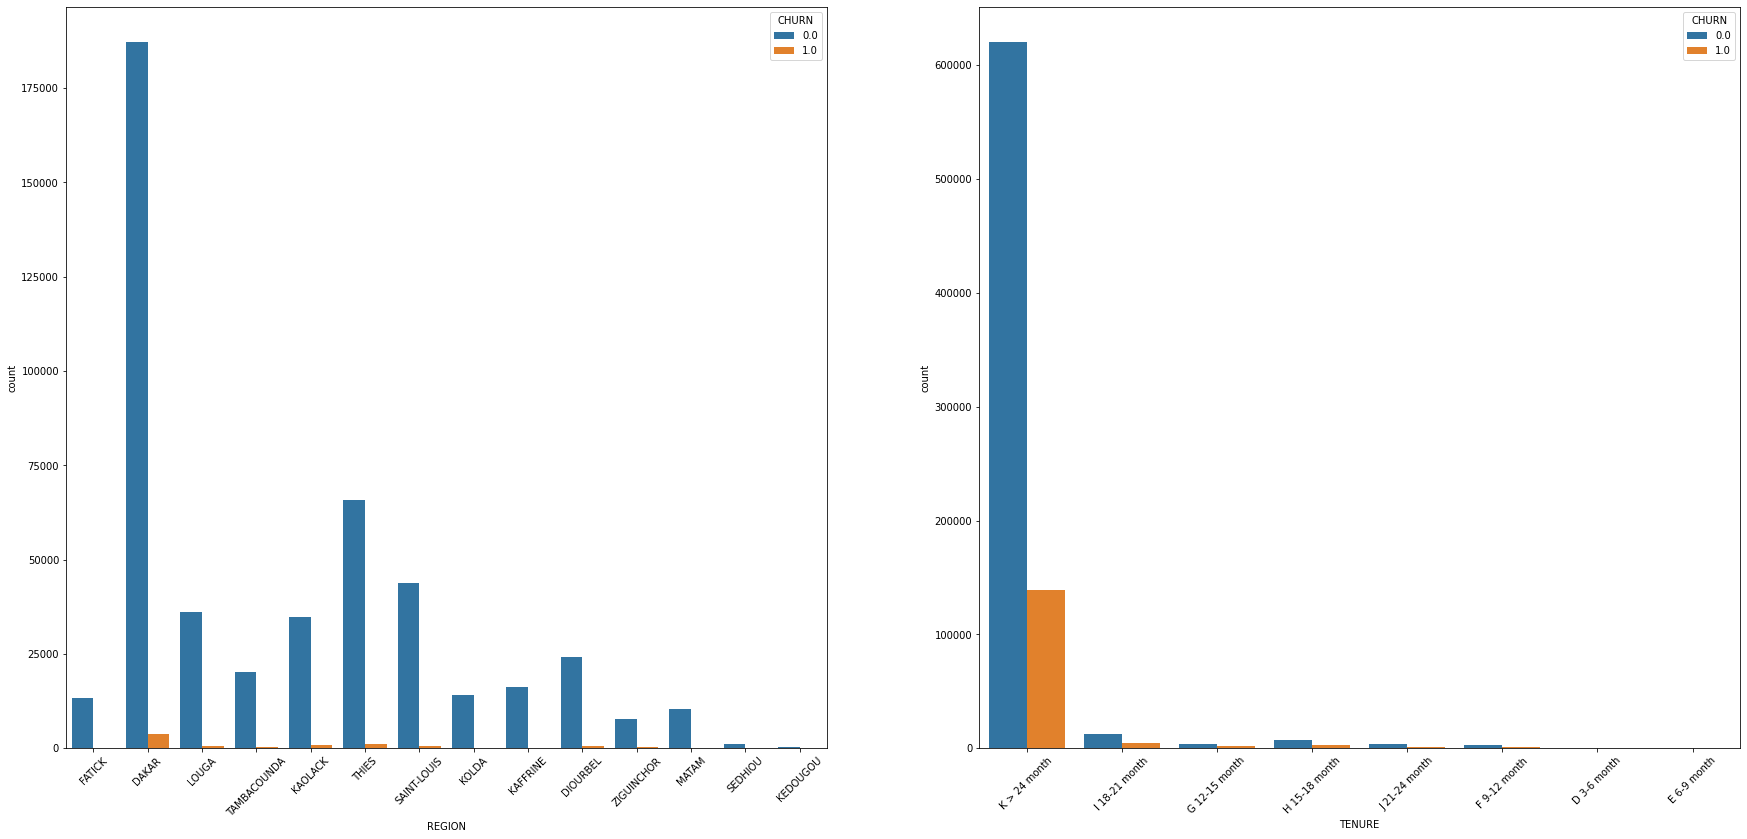

In [12]:
catCols = ['REGION', 'TENURE']
plt.figure(figsize=(30,30))
for i in enumerate(catCols):
  plt.subplot(2, 2, i[0]+1)
  sns.countplot(i[1], hue="CHURN", data=all_data)
  plt.xticks(rotation=45)

###Numerical features

In [13]:
numCols = all_data.select_dtypes(include=['int64', 'float64'])
numCols = numCols.drop('CHURN', axis=1)
numCols.describe().T

,count,mean,std,min,25%,50%,75%,max
MONTANT,766285.0,5532.461520,7130.066023,10.0,1000.0,3000.0,7350.0,470000.0
FREQUENCE_RECH,766285.0,11.532474,13.263113,1.0,2.0,7.0,16.0,146.0
REVENUE,783268.0,5508.421967,7193.947599,1.0,1000.0,3000.0,7372.0,532177.0
ARPU_SEGMENT,783268.0,1836.146558,2397.978214,0.0,333.0,1000.0,2457.0,177392.0
FREQUENCE,783268.0,13.977313,14.680887,1.0,3.0,9.0,20.0,91.0
DATA_VOLUME,599105.0,3368.516255,12638.736083,0.0,0.0,261.0,2899.0,1352304.0
ON_NET,749430.0,278.074004,873.754393,0.0,5.0,27.0,157.0,50809.0
ORANGE,690520.0,95.432581,205.913520,0.0,7.0,29.0,99.0,21323.0
TIGO,474254.0,23.016354,63.623803,0.0,2.0,6.0,20.0,3728.0
ZONE1,92903.0,8.119458,46.601958,0.0,0.0,1.0,3.0,4792.0


In [14]:
numColumns = []
for i in numCols.columns:
  numColumns.append(i)

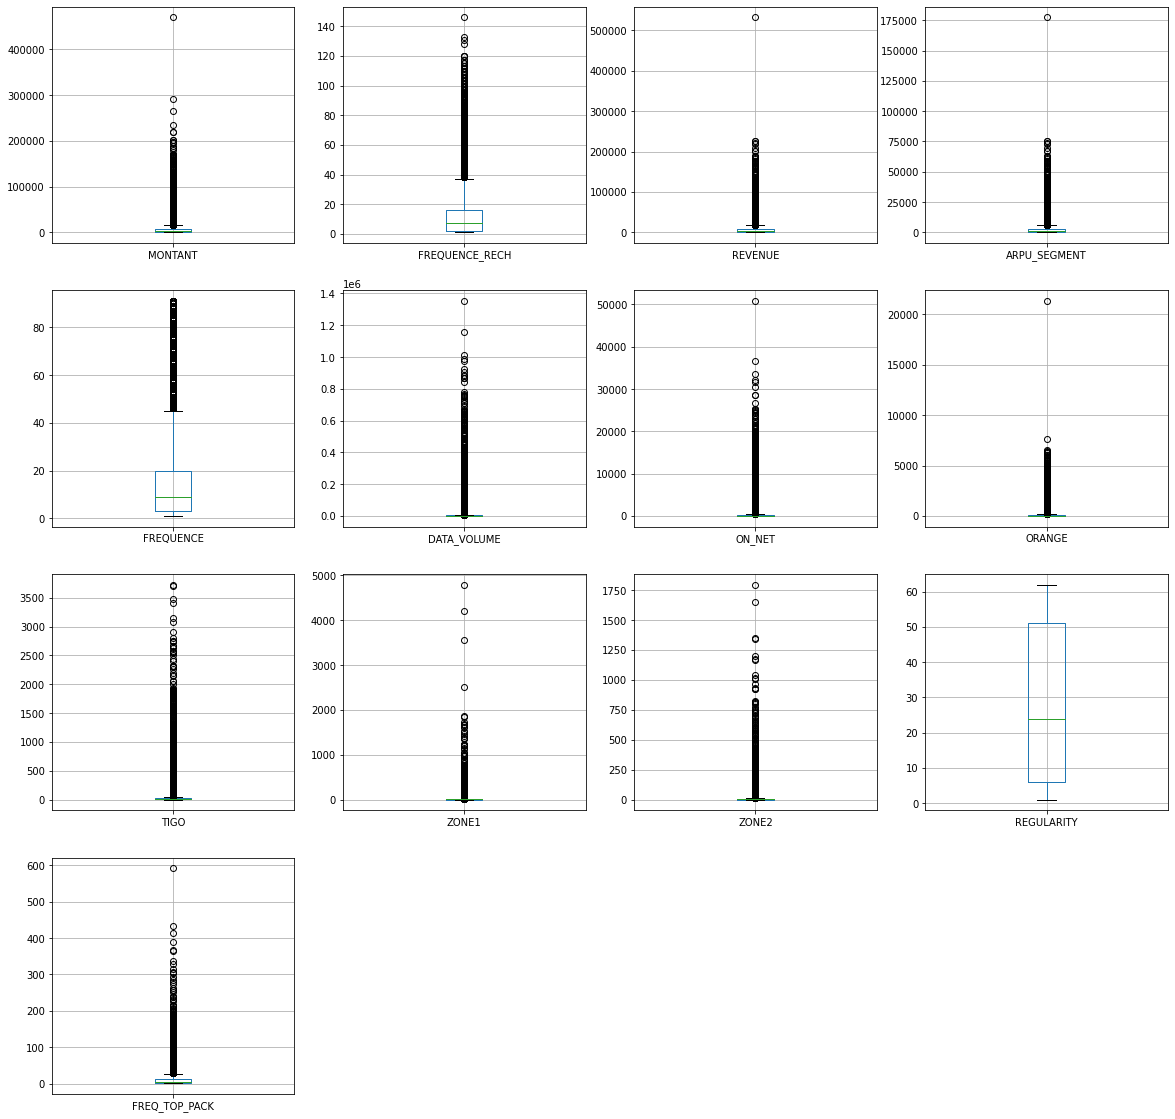

In [15]:
plt.figure(figsize=(20,20))
for i in enumerate(numColumns):
  plt.subplot(4, 4, i[0]+1)
  all_data.boxplot(column=i[1])
plt.show()

# Preprocessing

In [16]:
all_data['TOP_PACK'].unique()

array(['On net 200F=Unlimited _call24H', nan, 'On-net 1000F=10MilF;10d',
       'Data:1000F=5GB,7d', 'Mixt 250F=Unlimited_call24H',
       'MIXT:500F= 2500F on net _2500F off net;2d',
       'All-net 500F=2000F;5d', 'On-net 500F_FNF;3d',
       'Data: 100 F=40MB,24H', 'MIXT: 200mnoff net _unl on net _5Go;30d',
       'Jokko_Daily', 'Data: 200 F=100MB,24H', 'Data:490F=1GB,7d',
       'Twter_U2opia_Daily', 'On-net 500=4000,10d', 'Data:1000F=2GB,30d',
       'IVR Echat_Daily_50F', 'Pilot_Youth4_490',
       'All-net 500F =2000F_AllNet_Unlimited', 'Twter_U2opia_Weekly',
       'Data:200F=Unlimited,24H', 'On-net 200F=60mn;1d',
       'All-net 600F= 3000F ;5d', 'Pilot_Youth1_290',
       'All-net 1000F=(3000F On+3000F Off);5d', 'VAS(IVR_Radio_Daily)',
       'Data:3000F=10GB,30d', 'All-net 1000=5000;5d',
       'Twter_U2opia_Monthly', 'MIXT: 390F=04HOn-net_400SMS_400 Mo;4h\t',
       'FNF2 ( JAPPANTE)', 'Yewouleen_PKG', 'Data:150F=SPPackage1,24H',
       'WIFI_Family_2MBPS', 'Data:500F=2GB,2

In [17]:
all_data.drop(columns=['TOP_PACK'], axis=1, inplace=True)

### Missing values

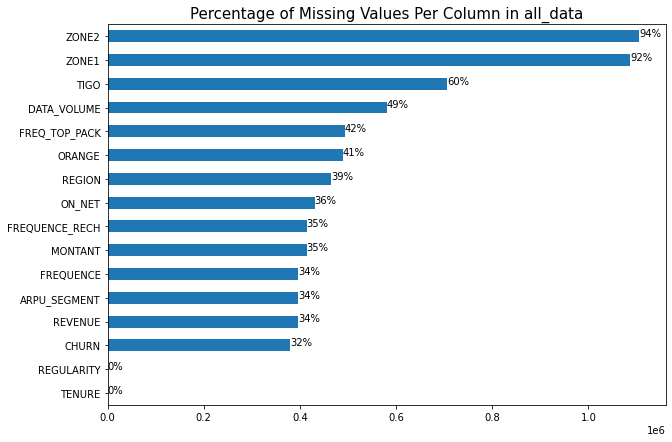

In [18]:
# Check if there any missing values in all_data 
ax = all_data.isna().sum().sort_values().plot(kind = 'barh', figsize = (10, 7))
plt.title('Percentage of Missing Values Per Column in all_data', fontdict={'size':15})
for p in ax.patches:
    percentage ='{:,.0f}%'.format((p.get_width()/all_data.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y)) 

##### We will replace the missing values for the numerical columns with their median.

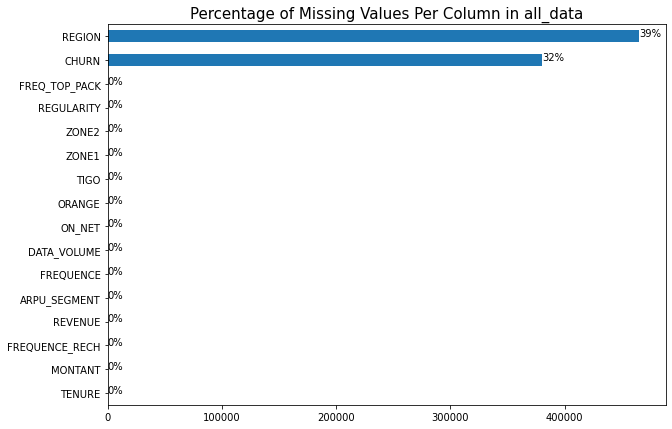

In [19]:
all_data['MONTANT'].fillna((all_data['MONTANT'].median()), inplace=True)
all_data['FREQUENCE_RECH'].fillna((all_data['FREQUENCE_RECH'].median()), inplace=True)
all_data['REVENUE'].fillna((all_data['REVENUE'].median()), inplace=True)
all_data['ARPU_SEGMENT'].fillna((all_data['ARPU_SEGMENT'].median()), inplace=True)
all_data['FREQUENCE'].fillna((all_data['FREQUENCE'].median()), inplace=True)
all_data['DATA_VOLUME'].fillna((all_data['DATA_VOLUME'].median()), inplace=True)
all_data['ON_NET'].fillna((all_data['ON_NET'].median()), inplace=True)
all_data['ORANGE'].fillna((all_data['ORANGE'].median()), inplace=True)
all_data['TIGO'].fillna((all_data['TIGO'].median()), inplace=True)
all_data['ZONE1'].fillna((all_data['ZONE1'].median()), inplace=True)
all_data['ZONE2'].fillna((all_data['ZONE2'].median()), inplace=True)
all_data['FREQ_TOP_PACK'].fillna((all_data['FREQ_TOP_PACK'].median()), inplace=True)

ax = all_data.isna().sum().sort_values().plot(kind = 'barh', figsize = (10, 7))
plt.title('Percentage of Missing Values Per Column in all_data', fontdict={'size':15})
for p in ax.patches:
    percentage ='{:,.0f}%'.format((p.get_width()/all_data.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y)) 

In [20]:
# We will replace the missing values for the categorical columns with the mode.
all_data['REGION'].fillna((all_data['REGION'].mode()[0]), inplace=True)

In [21]:
all_data.isna().sum()

REGION                 0
TENURE                 0
MONTANT                0
FREQUENCE_RECH         0
REVENUE                0
ARPU_SEGMENT           0
FREQUENCE              0
DATA_VOLUME            0
ON_NET                 0
ORANGE                 0
TIGO                   0
ZONE1                  0
ZONE2                  0
REGULARITY             0
FREQ_TOP_PACK          0
CHURN             380127
dtype: int64

### Encoding

In [22]:
all_data['TENURE'].unique()

array(['K > 24 month', 'I 18-21 month', 'G 12-15 month', 'H 15-18 month',
       'J 21-24 month', 'F 9-12 month', 'D 3-6 month', 'E 6-9 month'],
      dtype=object)

In [23]:
all_data['TENURE'] = all_data['TENURE'].map({'K > 24 month': 24, 'I 18-21 month': (18+21)/2, 'G 12-15 month': (12+15)/2, 'H 15-18 month':(15+18)/2,
                                             'J 21-24 month': (21+24)/2, 'F 9-12 month': (9+12)/2, 'E 6-9 month':(6+9)/2, 'D 3-6 month':(3+6)+2})

### Creating new features

In [24]:
all_data['MONTANT/REVENUE'] = all_data['MONTANT'] / all_data['REVENUE'] 

all_data['DATA_VOLUME_REGULARITY'] = all_data['DATA_VOLUME'] / all_data['REGULARITY'] 

In [25]:
all_data['TOTAL_CALLS'] = all_data['ON_NET'] + all_data['ORANGE'] + all_data['TIGO'] + all_data['ZONE1'] + all_data['ZONE2']

all_data['ON_NET_FREQ'] = all_data['ON_NET'] / all_data['TOTAL_CALLS']
all_data['ORANGE_FREQ'] = all_data['ORANGE'] / all_data['TOTAL_CALLS']
all_data['TIGO_FREQ'] = all_data['TIGO'] / all_data['TOTAL_CALLS']
all_data['ZONE1_FREQ'] = all_data['ZONE1'] / all_data['TOTAL_CALLS']
all_data['ZONE2_FREQ'] = all_data['ZONE1'] / all_data['TOTAL_CALLS']
all_data['FREQ'] = all_data['FREQUENCE'] / all_data['FREQUENCE_RECH']
all_data['ARPU_SEGMENT_REGULARITY'] = all_data['ARPU_SEGMENT'] / all_data['REGULARITY'] 

all_data['log_MONTANT'] = np.log1p(all_data['MONTANT']) 
all_data['log_REVENUE'] = np.log1p(all_data['REVENUE'])
all_data['log_FREQUENCE'] = np.log1p(all_data['FREQUENCE'])
all_data['log_FREQUENCE_RECH'] = np.log1p(all_data['FREQUENCE_RECH'])
all_data['log_REGULARITY'] = np.log1p(all_data['REGULARITY'])
all_data['log_DATA_VOLUME'] = np.log1p(all_data['DATA_VOLUME'])

all_data['log_MONTANT/REVENUE'] = all_data['log_MONTANT'] / all_data['log_REVENUE'] 
all_data['log_DATA_VOLUME/REGULARITY'] = all_data['log_DATA_VOLUME'] / all_data['log_REGULARITY'] 

In [26]:
regions = all_data.groupby('REGION').mean()
new_cols = []
for i in regions.columns:
    if i != 'REGION':
        regions[i+'_mean_region'] = regions[i]
        regions.drop(i, 1, inplace = True)

all_data = pd.merge(all_data, regions, on='REGION', how = 'left')

In [27]:
all_data.drop('REGION', axis=1, inplace=True)

In [28]:
all_data.shape

(1180127, 66)

#Feature selection

Variance Threshold = Feature selector that removes all low-variance features.



In [29]:
all_data_churn = pd.DataFrame(all_data['CHURN'])

In [30]:
all_data_normalized = all_data / all_data.mean()
all_data_normalized.var()

TENURE                                    0.005084
MONTANT                                   1.598053
FREQUENCE_RECH                            1.202665
REVENUE                                   1.643004
ARPU_SEGMENT                              1.642991
                                            ...   
log_FREQUENCE_RECH_mean_region            0.001184
log_REGULARITY_mean_region                0.020656
log_DATA_VOLUME_mean_region               0.008605
log_MONTANT/REVENUE_mean_region           0.000311
log_DATA_VOLUME/REGULARITY_mean_region    0.079314
Length: 66, dtype: float64

In [31]:
vt = VarianceThreshold(0.01)
_ = vt.fit(all_data_normalized)

# Get the mask
mask = vt.get_support()

# Subset the DataFrame
all_data_selected = all_data.loc[:, mask]
all_data_selected.shape

(1180127, 49)

In [32]:
selected_cols = []
for i in all_data_selected.columns:
  selected_cols.append(i)
len(selected_cols)

49

In [33]:
all_data = all_data[selected_cols]
all_data.shape

(1180127, 49)

In [34]:
all_data['CHURN'] = all_data_churn

### Separate train and test data from the combined dataframe


In [35]:
train = all_data[:ntrain].copy()
target = train.CHURN.copy()
train.drop('CHURN', axis=1, inplace=True)

test = all_data[ntrain:].copy()
test.drop('CHURN', axis=1, inplace=True)
test = test.reset_index(drop=True)

In [36]:
print(train.shape)
print(test.shape)

(800000, 48)
(380127, 48)


# Machine learning 

## **Stacking ensembles**

In [37]:
#comment later
def evaluate(ytest, ypred, y_predproba): 
  print("Acuracy", accuracy_score(ytest, ypred))
  print("_"*8)
  print("Recall", recall_score(ytest, ypred))
  print("_"*8)
  print("F1 Score", f1_score(ytest, ypred))

  confusion = confusion_matrix(ytest, ypred)
  group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
  group_counts = ['{0:0.0f}'.format(value) for value in
                  confusion.flatten()]
  group_percentages = ['{0:.2%}'.format(value) for value in
                      confusion.flatten()/np.sum(confusion)]
  labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
            zip(group_names,group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  matrix = sns.heatmap(confusion, annot=labels, fmt='', cmap='Blues')
  matrix
  figsize=(10, 6)

  fpr, tpr, thresholds = roc_curve(ytest, y_predproba)
  auc = roc_auc_score(ytest, y_predproba)
  plt.figure(figsize=(10,5))

  # Plot the ROC curve
  plt.plot(fpr,tpr,label="AUC="+str(auc))

  # Add labels and diagonal line
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")

  plt.legend(loc=4)
  plt.plot([0, 1], [0, 1], "k--")
  plt.show()
  return

In [38]:
lgbm = LGBMClassifier(objective =  'binary', 
                            metric= 'auc',
                            boosting_type= 'gbdt',
                            lambda_l1= 0.0004912993970392775,
                            lambda_l2= 9.424350138808432,
                            num_leaves= 24,
                            feature_fraction= 1.0,
                            bagging_fraction= 0.9540416539312312,
                            bagging_freq= 7,
                            min_child_samples= 100, n_estimators = 300)

xgboost = XGBClassifier(objective ='binary:logistic', 
                          eta = 0.99,
                          max_depth = 6, 
                          n_estimators = 5000,
                          reg_lambda = 500,
                          sub_sample = 0.8,
                          colsample_bytree = 0.8, 
                          tree_method='gpu_hist', gpu_id=0
                        )

catboost = CatBoostClassifier(n_estimators=10000, max_depth=6, eval_metric='AUC', reg_lambda = 370, task_type="GPU", devices='0:1')

In [41]:
def training_model(model, modelName, train, test):

  auc_scores = []
  kf = StratifiedKFold(n_splits = 7)
  y_preds = np.zeros(train.shape[0])
  test_preds = np.zeros(test.shape[0])

  def lightgbm_(x_train, x_test, y_train, y_test, test_preds):
    model.fit(x_train, y_train, early_stopping_rounds = 30, eval_metric="auc",
                           eval_set=[(x_test, y_test)], verbose = True)
    y_pred_proba = model.predict_proba(x_test, num_iteration = model.best_iteration_)[:,1] 
    y_pred = model.predict(x_test, num_iteration = model.best_iteration_)
    y_preds[test_index] = y_pred_proba 
    test_preds += model.predict_proba(test, num_iteration = model.best_iteration_)[:,1]
    return y_pred_proba, y_pred

  def catboost_(x_train, x_test, y_train, y_test, test_preds):
    model.fit(x_train,y_train,eval_set=[(x_test,y_test)],early_stopping_rounds=500,
                           verbose=50,use_best_model=True)
    y_pred_proba = model.predict_proba(x_test)[:,1] 
    y_pred = model.predict(x_test)
    y_preds[test_index] = y_pred_proba 
    test_preds += model.predict_proba(test)[:,1]
    return y_pred_proba, y_pred
  
  def xgboost_(x_train, x_test, y_train, y_test, test_preds):
    model.fit(x_train, y_train, early_stopping_rounds = 30, eval_metric="auc",
                           eval_set=[(x_test, y_test)], verbose = True)
    y_pred_proba = model.predict_proba(x_test, ntree_limit = model.get_booster().best_ntree_limit)[:,1]
    y_pred = model.predict(x_test, ntree_limit = model.get_booster().best_ntree_limit)
    y_preds[test_index] = y_pred_proba 
    test_preds += model.predict_proba(test, ntree_limit = model.get_booster().best_ntree_limit)[:,1]
    return y_pred_proba, y_pred

  for count, (train_index, test_index) in enumerate(kf.split(train, target)):
      x_train,x_test = train.iloc[train_index], train.iloc[test_index]
      y_train,y_test = target.iloc[train_index], target.iloc[test_index]
      print(f"================================Fold {count+1}====================================")
      
      if modelName == 'xgboost':
        y_pred_proba, y_pred = xgboost_(x_train, x_test, y_train, y_test, test_preds)
      elif modelName == 'lightgbm':
        y_pred_proba, y_pred = lightgbm_(x_train, x_test, y_train, y_test, test_preds)
      elif modelName == 'catboost':
        y_pred_proba, y_pred = catboost_(x_train, x_test, y_train, y_test, test_preds)
        
      evaluate(y_test, y_pred, y_pred_proba)
      print('\nValidation auc:', roc_auc_score(y_test, y_pred_proba))
      auc_scores.append(roc_auc_score(y_test, y_pred_proba))
  print('Mean AUC ', np.mean(auc_scores))
  return y_preds, test_preds/7

================================Fold 1====================================
[1]	valid_0's auc: 0.912531
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's auc: 0.914054
[3]	valid_0's auc: 0.91438
[4]	valid_0's auc: 0.914583
[5]	valid_0's auc: 0.914721
[6]	valid_0's auc: 0.914901
[7]	valid_0's auc: 0.91506
[8]	valid_0's auc: 0.915032
[9]	valid_0's auc: 0.91516
[10]	valid_0's auc: 0.91519
[11]	valid_0's auc: 0.915512
[12]	valid_0's auc: 0.915617
[13]	valid_0's auc: 0.915687
[14]	valid_0's auc: 0.915742
[15]	valid_0's auc: 0.91581
[16]	valid_0's auc: 0.91584
[17]	valid_0's auc: 0.915883
[18]	valid_0's auc: 0.915885
[19]	valid_0's auc: 0.915982
[20]	valid_0's auc: 0.916045
[21]	valid_0's auc: 0.916106
[22]	valid_0's auc: 0.916153
[23]	valid_0's auc: 0.916183
[24]	valid_0's auc: 0.91625
[25]	valid_0's auc: 0.916284
[26]	valid_0's auc: 0.916332
[27]	valid_0's auc: 0.916401
[28]	valid_0's auc: 0.916434
[29]	valid_0's auc: 0.916486
[30]	valid_0's auc: 0.916501
[31]	vali

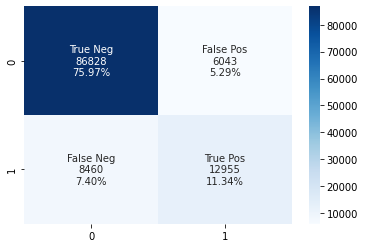

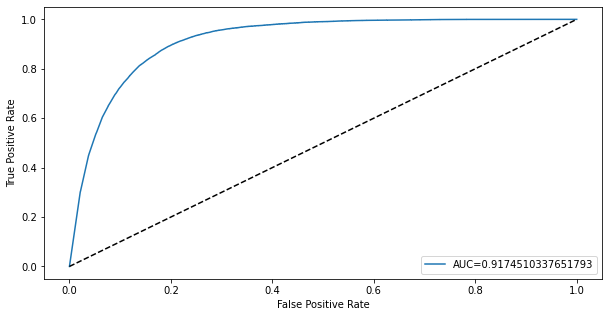


Validation auc: 0.9174510337651793
================================Fold 2====================================
[1]	valid_0's auc: 0.911766
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's auc: 0.913186
[3]	valid_0's auc: 0.913509
[4]	valid_0's auc: 0.913804
[5]	valid_0's auc: 0.91397
[6]	valid_0's auc: 0.914029
[7]	valid_0's auc: 0.914117
[8]	valid_0's auc: 0.914255
[9]	valid_0's auc: 0.914329
[10]	valid_0's auc: 0.914617
[11]	valid_0's auc: 0.914701
[12]	valid_0's auc: 0.914748
[13]	valid_0's auc: 0.914841
[14]	valid_0's auc: 0.914836
[15]	valid_0's auc: 0.914955
[16]	valid_0's auc: 0.915066
[17]	valid_0's auc: 0.915142
[18]	valid_0's auc: 0.915195
[19]	valid_0's auc: 0.915307
[20]	valid_0's auc: 0.915318
[21]	valid_0's auc: 0.915354
[22]	valid_0's auc: 0.915403
[23]	valid_0's auc: 0.915429
[24]	valid_0's auc: 0.915485
[25]	valid_0's auc: 0.915563
[26]	valid_0's auc: 0.915607
[27]	valid_0's auc: 0.915636
[28]	valid_0's auc: 0.915681
[29]	valid_0's auc: 0.915

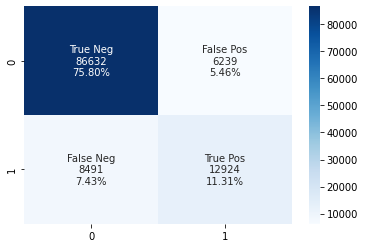

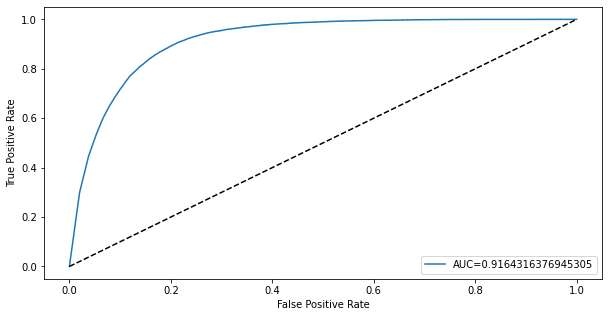


Validation auc: 0.9164316376945305
================================Fold 3====================================
[1]	valid_0's auc: 0.91315
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's auc: 0.914355
[3]	valid_0's auc: 0.914794
[4]	valid_0's auc: 0.915134
[5]	valid_0's auc: 0.915252
[6]	valid_0's auc: 0.915295
[7]	valid_0's auc: 0.915376
[8]	valid_0's auc: 0.915483
[9]	valid_0's auc: 0.915752
[10]	valid_0's auc: 0.915859
[11]	valid_0's auc: 0.91594
[12]	valid_0's auc: 0.916042
[13]	valid_0's auc: 0.91609
[14]	valid_0's auc: 0.916152
[15]	valid_0's auc: 0.91622
[16]	valid_0's auc: 0.916281
[17]	valid_0's auc: 0.916335
[18]	valid_0's auc: 0.916392
[19]	valid_0's auc: 0.916418
[20]	valid_0's auc: 0.916487
[21]	valid_0's auc: 0.916546
[22]	valid_0's auc: 0.91659
[23]	valid_0's auc: 0.916649
[24]	valid_0's auc: 0.916699
[25]	valid_0's auc: 0.916737
[26]	valid_0's auc: 0.916761
[27]	valid_0's auc: 0.916804
[28]	valid_0's auc: 0.916863
[29]	valid_0's auc: 0.916929


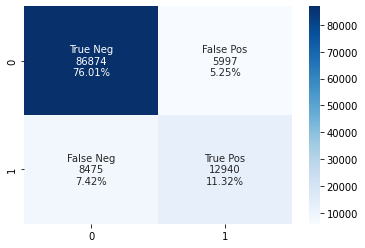

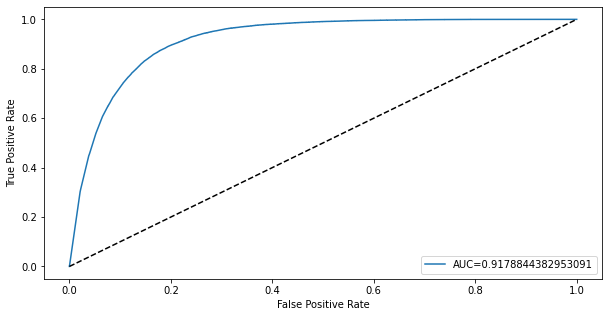


Validation auc: 0.9178844382953091
================================Fold 4====================================
[1]	valid_0's auc: 0.913976
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's auc: 0.915536
[3]	valid_0's auc: 0.915796
[4]	valid_0's auc: 0.91616
[5]	valid_0's auc: 0.916236
[6]	valid_0's auc: 0.916379
[7]	valid_0's auc: 0.916568
[8]	valid_0's auc: 0.916687
[9]	valid_0's auc: 0.91669
[10]	valid_0's auc: 0.917008
[11]	valid_0's auc: 0.917193
[12]	valid_0's auc: 0.917306
[13]	valid_0's auc: 0.917371
[14]	valid_0's auc: 0.917443
[15]	valid_0's auc: 0.917525
[16]	valid_0's auc: 0.917557
[17]	valid_0's auc: 0.917605
[18]	valid_0's auc: 0.917616
[19]	valid_0's auc: 0.91766
[20]	valid_0's auc: 0.917701
[21]	valid_0's auc: 0.917734
[22]	valid_0's auc: 0.917781
[23]	valid_0's auc: 0.917832
[24]	valid_0's auc: 0.917869
[25]	valid_0's auc: 0.917889
[26]	valid_0's auc: 0.91792
[27]	valid_0's auc: 0.917948
[28]	valid_0's auc: 0.917981
[29]	valid_0's auc: 0.918027

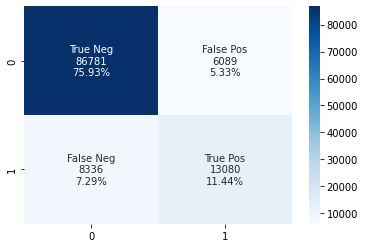

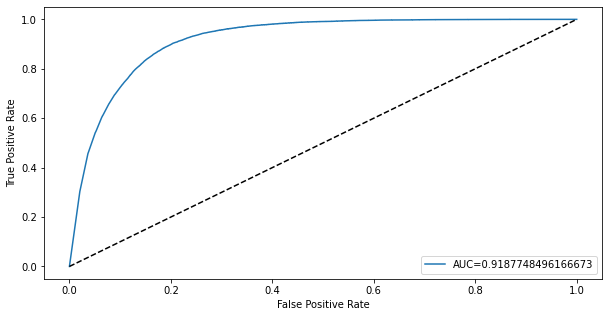


Validation auc: 0.9187748496166673
================================Fold 5====================================
[1]	valid_0's auc: 0.911404
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's auc: 0.912654
[3]	valid_0's auc: 0.913148
[4]	valid_0's auc: 0.913278
[5]	valid_0's auc: 0.913306
[6]	valid_0's auc: 0.913397
[7]	valid_0's auc: 0.913747
[8]	valid_0's auc: 0.913873
[9]	valid_0's auc: 0.914178
[10]	valid_0's auc: 0.91428
[11]	valid_0's auc: 0.914329
[12]	valid_0's auc: 0.914389
[13]	valid_0's auc: 0.91452
[14]	valid_0's auc: 0.914601
[15]	valid_0's auc: 0.914703
[16]	valid_0's auc: 0.914793
[17]	valid_0's auc: 0.914829
[18]	valid_0's auc: 0.914886
[19]	valid_0's auc: 0.914969
[20]	valid_0's auc: 0.915011
[21]	valid_0's auc: 0.915065
[22]	valid_0's auc: 0.915114
[23]	valid_0's auc: 0.915146
[24]	valid_0's auc: 0.915277
[25]	valid_0's auc: 0.915285
[26]	valid_0's auc: 0.915312
[27]	valid_0's auc: 0.915368
[28]	valid_0's auc: 0.915401
[29]	valid_0's auc: 0.9154

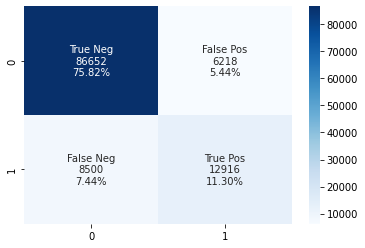

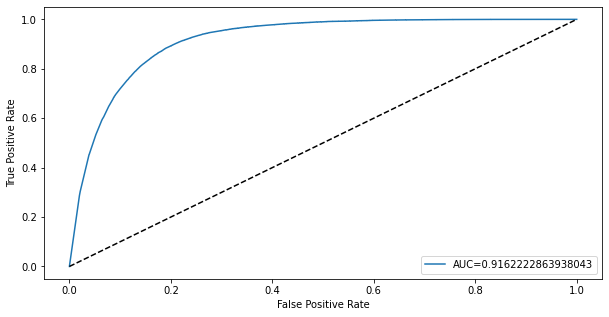


Validation auc: 0.9162222863938043
================================Fold 6====================================
[1]	valid_0's auc: 0.913418
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's auc: 0.914912
[3]	valid_0's auc: 0.915204
[4]	valid_0's auc: 0.915347
[5]	valid_0's auc: 0.915604
[6]	valid_0's auc: 0.915742
[7]	valid_0's auc: 0.915829
[8]	valid_0's auc: 0.915914
[9]	valid_0's auc: 0.916177
[10]	valid_0's auc: 0.916276
[11]	valid_0's auc: 0.916302
[12]	valid_0's auc: 0.916467
[13]	valid_0's auc: 0.916535
[14]	valid_0's auc: 0.916624
[15]	valid_0's auc: 0.916695
[16]	valid_0's auc: 0.916837
[17]	valid_0's auc: 0.916887
[18]	valid_0's auc: 0.916934
[19]	valid_0's auc: 0.916979
[20]	valid_0's auc: 0.917016
[21]	valid_0's auc: 0.917103
[22]	valid_0's auc: 0.917142
[23]	valid_0's auc: 0.9172
[24]	valid_0's auc: 0.917283
[25]	valid_0's auc: 0.917307
[26]	valid_0's auc: 0.917338
[27]	valid_0's auc: 0.917355
[28]	valid_0's auc: 0.917396
[29]	valid_0's auc: 0.9174

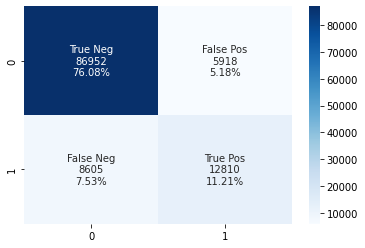

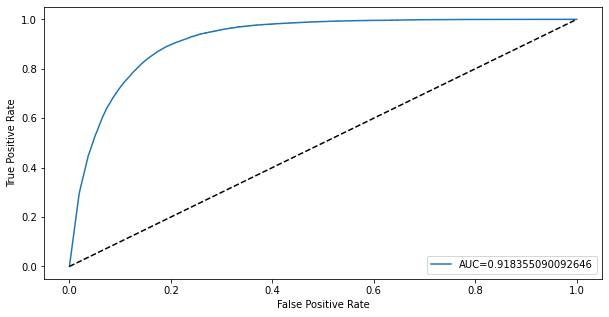


Validation auc: 0.918355090092646
================================Fold 7====================================
[1]	valid_0's auc: 0.912071
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's auc: 0.913445
[3]	valid_0's auc: 0.914075
[4]	valid_0's auc: 0.91447
[5]	valid_0's auc: 0.914595
[6]	valid_0's auc: 0.914645
[7]	valid_0's auc: 0.914698
[8]	valid_0's auc: 0.914805
[9]	valid_0's auc: 0.91502
[10]	valid_0's auc: 0.91515
[11]	valid_0's auc: 0.915295
[12]	valid_0's auc: 0.915406
[13]	valid_0's auc: 0.915478
[14]	valid_0's auc: 0.915504
[15]	valid_0's auc: 0.915632
[16]	valid_0's auc: 0.915721
[17]	valid_0's auc: 0.915811
[18]	valid_0's auc: 0.915834
[19]	valid_0's auc: 0.915889
[20]	valid_0's auc: 0.915947
[21]	valid_0's auc: 0.915983
[22]	valid_0's auc: 0.916025
[23]	valid_0's auc: 0.91605
[24]	valid_0's auc: 0.916113
[25]	valid_0's auc: 0.916137
[26]	valid_0's auc: 0.916216
[27]	valid_0's auc: 0.916234
[28]	valid_0's auc: 0.916285
[29]	valid_0's auc: 0.916314


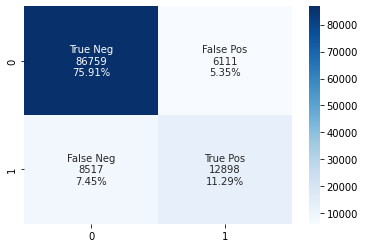

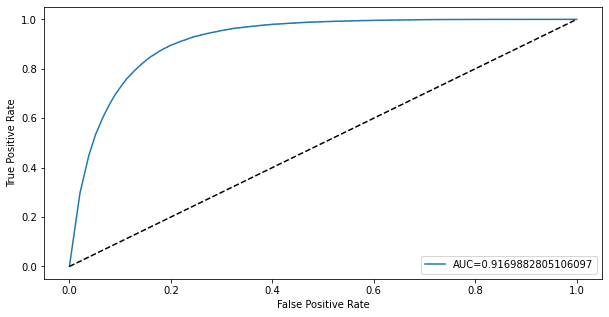


Validation auc: 0.9169882805106097
Mean AUC  0.9174439451955351


In [42]:
y_preds_lgbm, test_preds_lgbm = training_model(lgbm, "lightgbm", train, test)

================================Fold 1====================================
0:	learn: 0.9042876	test: 0.9040178	best: 0.9040178 (0)	total: 87.2ms	remaining: 14m 32s
50:	learn: 0.9150548	test: 0.9148362	best: 0.9148362 (50)	total: 4.85s	remaining: 15m 46s
100:	learn: 0.9160716	test: 0.9158205	best: 0.9158205 (100)	total: 6.88s	remaining: 11m 14s
150:	learn: 0.9166170	test: 0.9163227	best: 0.9163227 (150)	total: 8.84s	remaining: 9m 36s
200:	learn: 0.9168675	test: 0.9165364	best: 0.9165364 (200)	total: 10.6s	remaining: 8m 38s
250:	learn: 0.9170508	test: 0.9166839	best: 0.9166839 (250)	total: 12.4s	remaining: 8m 1s
300:	learn: 0.9172131	test: 0.9168009	best: 0.9168011 (299)	total: 14.2s	remaining: 7m 36s
350:	learn: 0.9173279	test: 0.9168757	best: 0.9168757 (350)	total: 15.9s	remaining: 7m 17s
400:	learn: 0.9174542	test: 0.9169548	best: 0.9169548 (400)	total: 17.7s	remaining: 7m 4s
450:	learn: 0.9175521	test: 0.9170273	best: 0.9170273 (450)	total: 19.5s	remaining: 6m 52s
500:	learn: 0.91764

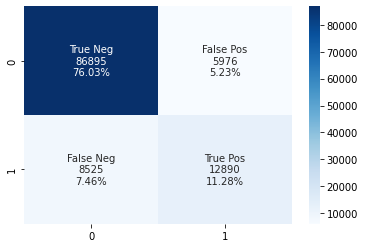

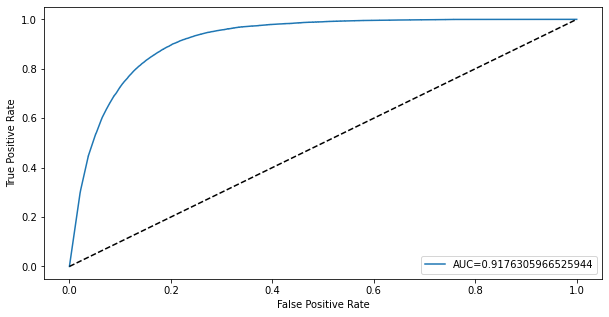


Validation auc: 0.9176305966525944
================================Fold 2====================================
0:	learn: 0.9043687	test: 0.9034100	best: 0.9034100 (0)	total: 45.1ms	remaining: 7m 30s
50:	learn: 0.9153136	test: 0.9142835	best: 0.9142835 (50)	total: 1.95s	remaining: 6m 19s
100:	learn: 0.9161768	test: 0.9150299	best: 0.9150299 (100)	total: 3.79s	remaining: 6m 11s
150:	learn: 0.9166790	test: 0.9154716	best: 0.9154716 (150)	total: 5.59s	remaining: 6m 4s
200:	learn: 0.9169752	test: 0.9157239	best: 0.9157239 (200)	total: 7.37s	remaining: 5m 59s
250:	learn: 0.9171908	test: 0.9158803	best: 0.9158803 (250)	total: 9.15s	remaining: 5m 55s
300:	learn: 0.9173401	test: 0.9159698	best: 0.9159698 (299)	total: 11.1s	remaining: 5m 58s
350:	learn: 0.9174771	test: 0.9160548	best: 0.9160548 (350)	total: 13.2s	remaining: 6m 1s
400:	learn: 0.9175834	test: 0.9161197	best: 0.9161198 (399)	total: 15.2s	remaining: 6m 3s
450:	learn: 0.9176851	test: 0.9161851	best: 0.9161856 (449)	total: 17.3s	remai

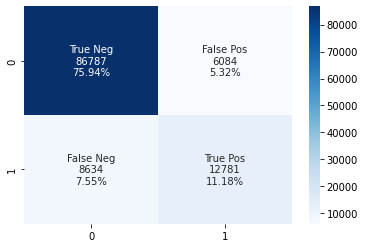

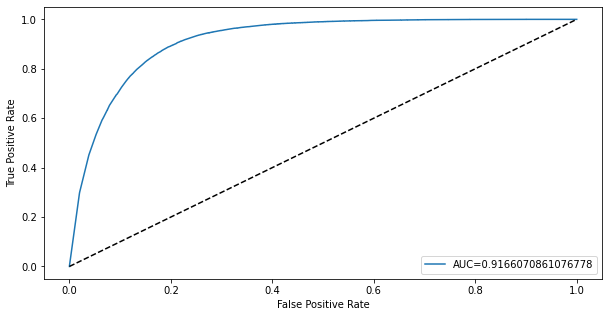


Validation auc: 0.9166070861076778
================================Fold 3====================================
0:	learn: 0.9031946	test: 0.9037078	best: 0.9037078 (0)	total: 44.8ms	remaining: 7m 27s
50:	learn: 0.9151424	test: 0.9153601	best: 0.9153601 (50)	total: 1.91s	remaining: 6m 13s
100:	learn: 0.9159986	test: 0.9162251	best: 0.9162251 (100)	total: 3.7s	remaining: 6m 3s
150:	learn: 0.9165179	test: 0.9167314	best: 0.9167314 (150)	total: 5.5s	remaining: 5m 58s
200:	learn: 0.9167977	test: 0.9169913	best: 0.9169914 (199)	total: 7.26s	remaining: 5m 53s
250:	learn: 0.9169823	test: 0.9171545	best: 0.9171545 (250)	total: 9.01s	remaining: 5m 49s
300:	learn: 0.9171305	test: 0.9172617	best: 0.9172617 (300)	total: 10.8s	remaining: 5m 47s
350:	learn: 0.9172629	test: 0.9173380	best: 0.9173380 (350)	total: 12.6s	remaining: 5m 45s
400:	learn: 0.9173773	test: 0.9174186	best: 0.9174186 (400)	total: 14.3s	remaining: 5m 42s
450:	learn: 0.9174628	test: 0.9174718	best: 0.9174744 (448)	total: 16.1s	remai

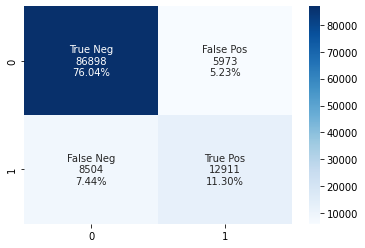

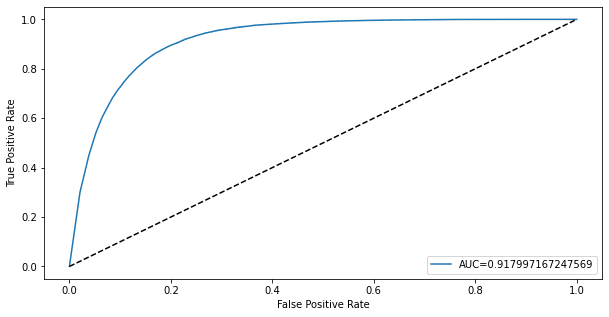


Validation auc: 0.917997167247569
================================Fold 4====================================
0:	learn: 0.9032155	test: 0.9050306	best: 0.9050306 (0)	total: 46.8ms	remaining: 7m 47s
50:	learn: 0.9146842	test: 0.9164207	best: 0.9164207 (50)	total: 1.95s	remaining: 6m 20s
100:	learn: 0.9157382	test: 0.9173976	best: 0.9173976 (100)	total: 3.77s	remaining: 6m 10s
150:	learn: 0.9163230	test: 0.9179158	best: 0.9179158 (150)	total: 5.57s	remaining: 6m 3s
200:	learn: 0.9166015	test: 0.9181225	best: 0.9181225 (200)	total: 7.32s	remaining: 5m 56s
250:	learn: 0.9168002	test: 0.9182602	best: 0.9182602 (250)	total: 9.1s	remaining: 5m 53s
300:	learn: 0.9169516	test: 0.9183529	best: 0.9183529 (300)	total: 10.9s	remaining: 5m 50s
350:	learn: 0.9170902	test: 0.9184356	best: 0.9184356 (350)	total: 12.7s	remaining: 5m 47s
400:	learn: 0.9172119	test: 0.9185171	best: 0.9185171 (400)	total: 14.4s	remaining: 5m 45s
450:	learn: 0.9173139	test: 0.9185775	best: 0.9185778 (449)	total: 16.2s	remai

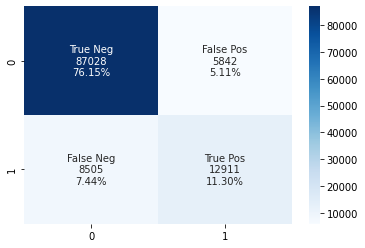

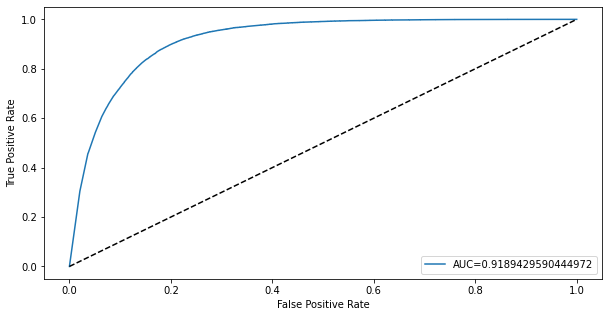


Validation auc: 0.9189429590444972
================================Fold 5====================================
0:	learn: 0.9037213	test: 0.9020054	best: 0.9020054 (0)	total: 46.1ms	remaining: 7m 41s
50:	learn: 0.9153664	test: 0.9137269	best: 0.9137269 (50)	total: 1.91s	remaining: 6m 13s
100:	learn: 0.9162610	test: 0.9145956	best: 0.9145956 (100)	total: 3.75s	remaining: 6m 7s
150:	learn: 0.9168192	test: 0.9151127	best: 0.9151127 (150)	total: 5.54s	remaining: 6m 1s
200:	learn: 0.9170919	test: 0.9153162	best: 0.9153175 (199)	total: 7.3s	remaining: 5m 56s
250:	learn: 0.9173005	test: 0.9154778	best: 0.9154801 (249)	total: 9.18s	remaining: 5m 56s
300:	learn: 0.9174362	test: 0.9155652	best: 0.9155660 (296)	total: 10.9s	remaining: 5m 52s
350:	learn: 0.9175691	test: 0.9156651	best: 0.9156651 (350)	total: 12.8s	remaining: 5m 50s
400:	learn: 0.9176731	test: 0.9157271	best: 0.9157271 (400)	total: 14.5s	remaining: 5m 46s
450:	learn: 0.9177615	test: 0.9157952	best: 0.9157956 (447)	total: 16.2s	remai

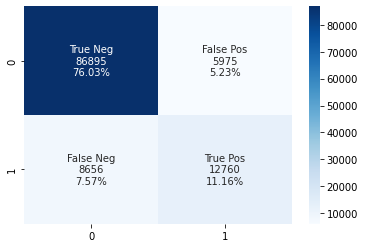

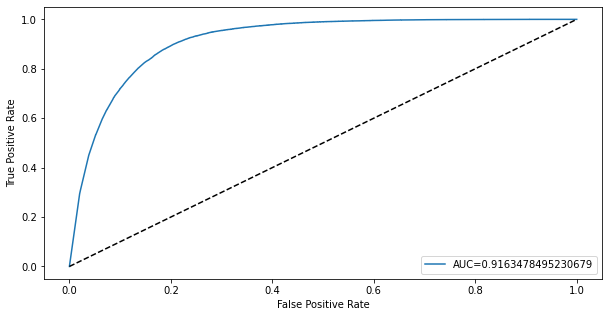


Validation auc: 0.9163478495230679
================================Fold 6====================================
0:	learn: 0.9031720	test: 0.9038401	best: 0.9038401 (0)	total: 44.6ms	remaining: 7m 26s
50:	learn: 0.9149554	test: 0.9158010	best: 0.9158010 (50)	total: 1.94s	remaining: 6m 18s
100:	learn: 0.9158762	test: 0.9167094	best: 0.9167094 (100)	total: 3.77s	remaining: 6m 9s
150:	learn: 0.9164217	test: 0.9172371	best: 0.9172371 (150)	total: 5.55s	remaining: 6m 1s
200:	learn: 0.9167410	test: 0.9175379	best: 0.9175379 (200)	total: 7.34s	remaining: 5m 57s
250:	learn: 0.9169368	test: 0.9176805	best: 0.9176818 (249)	total: 9.13s	remaining: 5m 54s
300:	learn: 0.9170856	test: 0.9177985	best: 0.9178002 (299)	total: 10.9s	remaining: 5m 50s
350:	learn: 0.9172065	test: 0.9178798	best: 0.9178798 (350)	total: 12.7s	remaining: 5m 48s
400:	learn: 0.9173173	test: 0.9179531	best: 0.9179531 (400)	total: 14.4s	remaining: 5m 45s
450:	learn: 0.9174057	test: 0.9180114	best: 0.9180114 (450)	total: 16.3s	rema

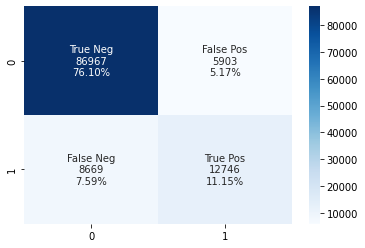

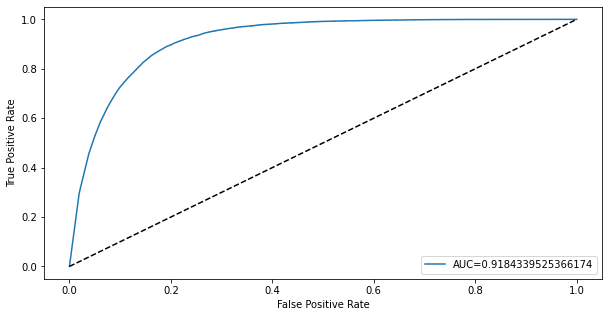


Validation auc: 0.9184339525366174
================================Fold 7====================================
0:	learn: 0.9034981	test: 0.9033369	best: 0.9033369 (0)	total: 43.8ms	remaining: 7m 18s
50:	learn: 0.9152194	test: 0.9147284	best: 0.9147284 (50)	total: 1.92s	remaining: 6m 13s
100:	learn: 0.9161009	test: 0.9155205	best: 0.9155205 (100)	total: 3.73s	remaining: 6m 5s
150:	learn: 0.9166613	test: 0.9159821	best: 0.9159821 (150)	total: 5.54s	remaining: 6m 1s
200:	learn: 0.9169631	test: 0.9162426	best: 0.9162426 (200)	total: 7.31s	remaining: 5m 56s
250:	learn: 0.9171634	test: 0.9163938	best: 0.9163938 (250)	total: 9.09s	remaining: 5m 52s
300:	learn: 0.9173116	test: 0.9164829	best: 0.9164829 (300)	total: 10.9s	remaining: 5m 50s
350:	learn: 0.9174372	test: 0.9165629	best: 0.9165629 (350)	total: 12.6s	remaining: 5m 47s
400:	learn: 0.9175355	test: 0.9166175	best: 0.9166185 (399)	total: 14.4s	remaining: 5m 44s
450:	learn: 0.9176398	test: 0.9166562	best: 0.9166594 (446)	total: 16.2s	rema

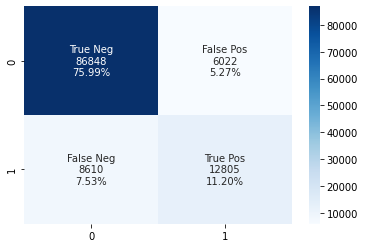

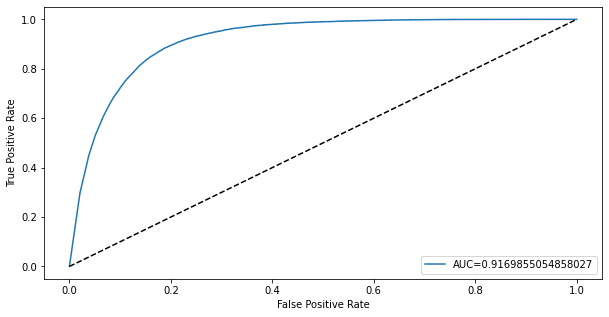


Validation auc: 0.9169855054858027
Mean AUC  0.9175635880854038


In [47]:
y_preds_cat, test_preds_cat = training_model(catboost, "catboost", train, test)

================================Fold 1====================================
[0]	validation_0-auc:0.883918
Will train until validation_0-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.890312
[2]	validation_0-auc:0.890956
[3]	validation_0-auc:0.894942
[4]	validation_0-auc:0.898922
[5]	validation_0-auc:0.898961
[6]	validation_0-auc:0.90152
[7]	validation_0-auc:0.903582
[8]	validation_0-auc:0.904515
[9]	validation_0-auc:0.905856
[10]	validation_0-auc:0.912395
[11]	validation_0-auc:0.9132
[12]	validation_0-auc:0.91342
[13]	validation_0-auc:0.913794
[14]	validation_0-auc:0.91417
[15]	validation_0-auc:0.914289
[16]	validation_0-auc:0.914366
[17]	validation_0-auc:0.914456
[18]	validation_0-auc:0.914518
[19]	validation_0-auc:0.914574
[20]	validation_0-auc:0.914775
[21]	validation_0-auc:0.914899
[22]	validation_0-auc:0.915054
[23]	validation_0-auc:0.915288
[24]	validation_0-auc:0.915383
[25]	validation_0-auc:0.915443
[26]	validation_0-auc:0.915518
[27]	validation_0-auc:0.915796
[28]	val

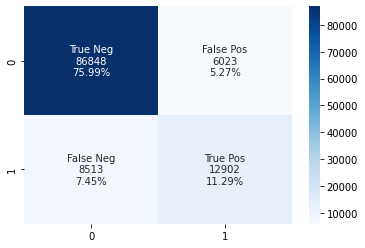

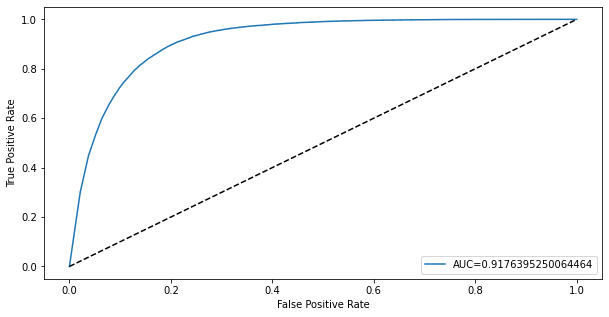


Validation auc: 0.9176395250064464
================================Fold 2====================================
[0]	validation_0-auc:0.883247
Will train until validation_0-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.889911
[2]	validation_0-auc:0.890275
[3]	validation_0-auc:0.894003
[4]	validation_0-auc:0.897798
[5]	validation_0-auc:0.897846
[6]	validation_0-auc:0.898916
[7]	validation_0-auc:0.901804
[8]	validation_0-auc:0.902794
[9]	validation_0-auc:0.902869
[10]	validation_0-auc:0.911212
[11]	validation_0-auc:0.911913
[12]	validation_0-auc:0.912364
[13]	validation_0-auc:0.912576
[14]	validation_0-auc:0.912975
[15]	validation_0-auc:0.913303
[16]	validation_0-auc:0.913385
[17]	validation_0-auc:0.913527
[18]	validation_0-auc:0.913616
[19]	validation_0-auc:0.913684
[20]	validation_0-auc:0.913843
[21]	validation_0-auc:0.913906
[22]	validation_0-auc:0.913983
[23]	validation_0-auc:0.914202
[24]	validation_0-auc:0.914466
[25]	validation_0-auc:0.914564
[26]	validation_0-auc:0.91482

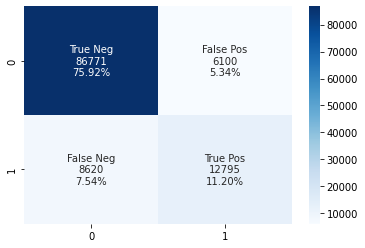

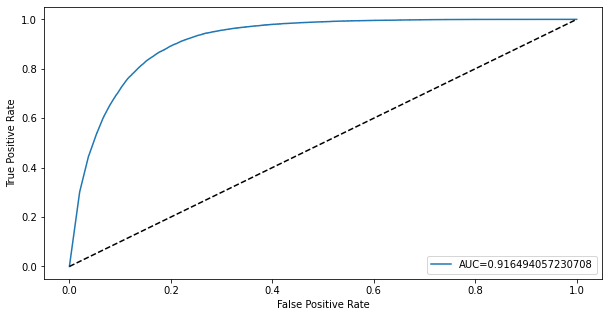


Validation auc: 0.916494057230708
================================Fold 3====================================
[0]	validation_0-auc:0.88437
Will train until validation_0-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.891395
[2]	validation_0-auc:0.891896
[3]	validation_0-auc:0.89687
[4]	validation_0-auc:0.899498
[5]	validation_0-auc:0.899494
[6]	validation_0-auc:0.901847
[7]	validation_0-auc:0.902002
[8]	validation_0-auc:0.903829
[9]	validation_0-auc:0.90624
[10]	validation_0-auc:0.912596
[11]	validation_0-auc:0.913721
[12]	validation_0-auc:0.913969
[13]	validation_0-auc:0.914155
[14]	validation_0-auc:0.914532
[15]	validation_0-auc:0.914859
[16]	validation_0-auc:0.914996
[17]	validation_0-auc:0.915065
[18]	validation_0-auc:0.915187
[19]	validation_0-auc:0.915335
[20]	validation_0-auc:0.915407
[21]	validation_0-auc:0.915464
[22]	validation_0-auc:0.915751
[23]	validation_0-auc:0.915867
[24]	validation_0-auc:0.91593
[25]	validation_0-auc:0.916172
[26]	validation_0-auc:0.916241
[27

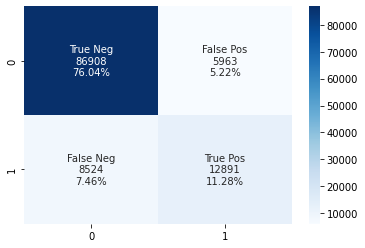

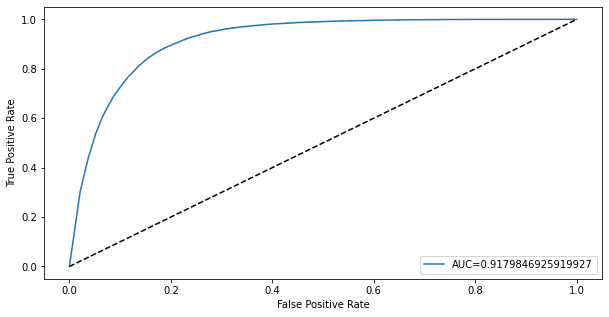


Validation auc: 0.9179846925919927
================================Fold 4====================================
[0]	validation_0-auc:0.885159
Will train until validation_0-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.892061
[2]	validation_0-auc:0.892606
[3]	validation_0-auc:0.895937
[4]	validation_0-auc:0.897743
[5]	validation_0-auc:0.900329
[6]	validation_0-auc:0.900529
[7]	validation_0-auc:0.904745
[8]	validation_0-auc:0.905099
[9]	validation_0-auc:0.907077
[10]	validation_0-auc:0.913407
[11]	validation_0-auc:0.914587
[12]	validation_0-auc:0.91494
[13]	validation_0-auc:0.915156
[14]	validation_0-auc:0.915616
[15]	validation_0-auc:0.915718
[16]	validation_0-auc:0.91589
[17]	validation_0-auc:0.916006
[18]	validation_0-auc:0.916088
[19]	validation_0-auc:0.916151
[20]	validation_0-auc:0.916209
[21]	validation_0-auc:0.916551
[22]	validation_0-auc:0.916625
[23]	validation_0-auc:0.916866
[24]	validation_0-auc:0.916959
[25]	validation_0-auc:0.917045
[26]	validation_0-auc:0.917363


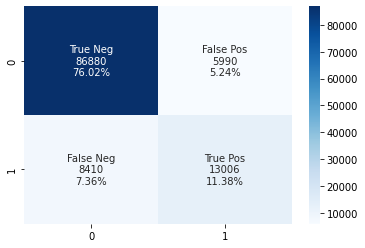

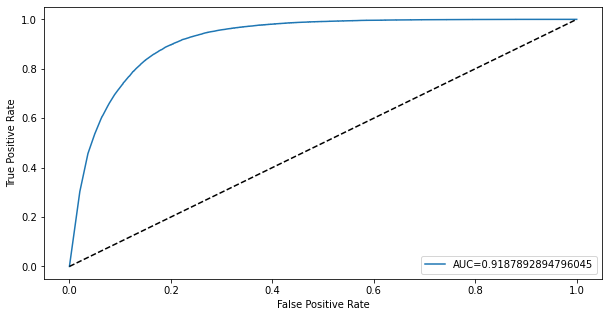


Validation auc: 0.9187892894796045
================================Fold 5====================================
[0]	validation_0-auc:0.882166
Will train until validation_0-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.887348
[2]	validation_0-auc:0.893087
[3]	validation_0-auc:0.894352
[4]	validation_0-auc:0.896932
[5]	validation_0-auc:0.902097
[6]	validation_0-auc:0.902505
[7]	validation_0-auc:0.902807
[8]	validation_0-auc:0.902906
[9]	validation_0-auc:0.910003
[10]	validation_0-auc:0.910134
[11]	validation_0-auc:0.911339
[12]	validation_0-auc:0.911984
[13]	validation_0-auc:0.912252
[14]	validation_0-auc:0.912818
[15]	validation_0-auc:0.913149
[16]	validation_0-auc:0.913268
[17]	validation_0-auc:0.91335
[18]	validation_0-auc:0.913446
[19]	validation_0-auc:0.913477
[20]	validation_0-auc:0.913631
[21]	validation_0-auc:0.913747
[22]	validation_0-auc:0.913874
[23]	validation_0-auc:0.914204
[24]	validation_0-auc:0.914297
[25]	validation_0-auc:0.914606
[26]	validation_0-auc:0.914661

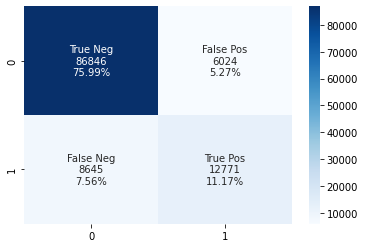

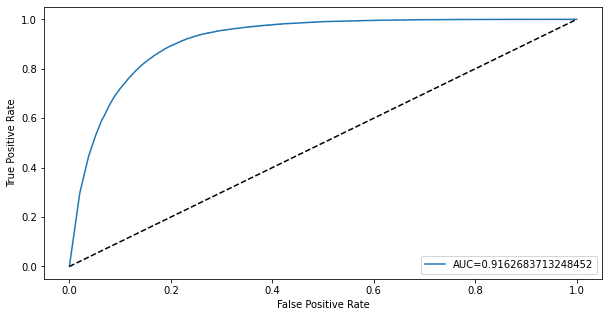


Validation auc: 0.9162683713248452
================================Fold 6====================================
[0]	validation_0-auc:0.884096
Will train until validation_0-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.888825
[2]	validation_0-auc:0.893255
[3]	validation_0-auc:0.89483
[4]	validation_0-auc:0.896429
[5]	validation_0-auc:0.899309
[6]	validation_0-auc:0.901793
[7]	validation_0-auc:0.90365
[8]	validation_0-auc:0.904502
[9]	validation_0-auc:0.912444
[10]	validation_0-auc:0.912698
[11]	validation_0-auc:0.913797
[12]	validation_0-auc:0.914114
[13]	validation_0-auc:0.914657
[14]	validation_0-auc:0.91472
[15]	validation_0-auc:0.915162
[16]	validation_0-auc:0.91525
[17]	validation_0-auc:0.915352
[18]	validation_0-auc:0.915441
[19]	validation_0-auc:0.915553
[20]	validation_0-auc:0.915636
[21]	validation_0-auc:0.915684
[22]	validation_0-auc:0.915933
[23]	validation_0-auc:0.916108
[24]	validation_0-auc:0.916215
[25]	validation_0-auc:0.9163
[26]	validation_0-auc:0.916552
[27]

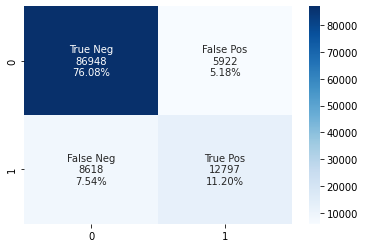

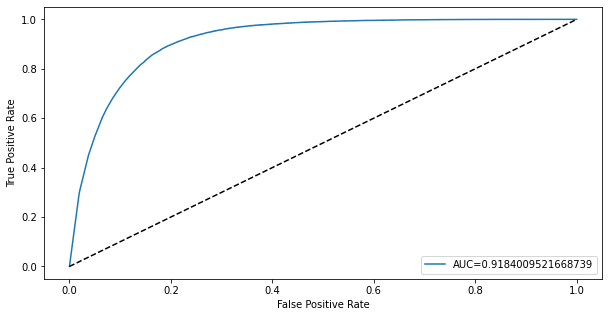


Validation auc: 0.9184009521668739
================================Fold 7====================================
[0]	validation_0-auc:0.883988
Will train until validation_0-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.889331
[2]	validation_0-auc:0.894585
[3]	validation_0-auc:0.894798
[4]	validation_0-auc:0.898829
[5]	validation_0-auc:0.903706
[6]	validation_0-auc:0.903843
[7]	validation_0-auc:0.9043
[8]	validation_0-auc:0.904543
[9]	validation_0-auc:0.904798
[10]	validation_0-auc:0.911962
[11]	validation_0-auc:0.912676
[12]	validation_0-auc:0.913048
[13]	validation_0-auc:0.91344
[14]	validation_0-auc:0.913601
[15]	validation_0-auc:0.91377
[16]	validation_0-auc:0.914078
[17]	validation_0-auc:0.914168
[18]	validation_0-auc:0.914306
[19]	validation_0-auc:0.91435
[20]	validation_0-auc:0.914451
[21]	validation_0-auc:0.914548
[22]	validation_0-auc:0.914755
[23]	validation_0-auc:0.915073
[24]	validation_0-auc:0.915169
[25]	validation_0-auc:0.915431
[26]	validation_0-auc:0.915457
[27

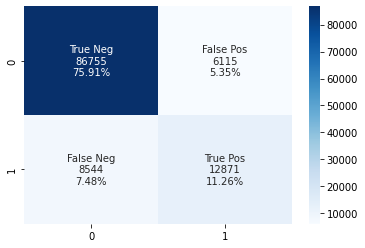

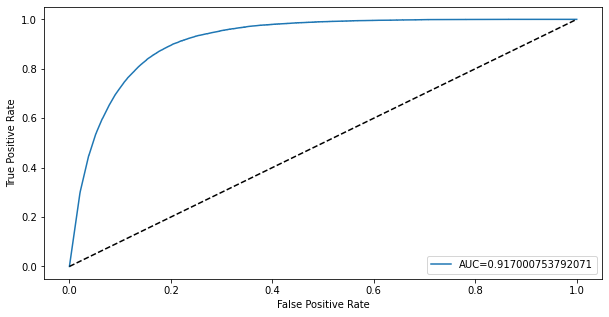


Validation auc: 0.917000753792071
Mean AUC  0.9175110916560775


In [48]:
y_preds_xgb, test_preds_xgb = training_model(xgboost, "xgboost", train, test)

In [49]:
y_preds_stacked = np.column_stack((y_preds_lgbm, y_preds_cat, y_preds_xgb))
test_preds_stacked = np.column_stack((test_preds_lgbm, test_preds_cat, test_preds_xgb))
predictions = LinearRegression().fit(y_preds_stacked, target).predict(test_preds_stacked)

In [50]:
predictions

array([0.0011243 , 0.03575097, 0.01415845, ..., 0.16144043, 0.07508807,
       0.01418913])

In [51]:
ss["CHURN"] = predictions
ss.head()
ss.to_csv('predictions.csv', index=False)

FURTHER IMPROVEMENTS TO DO:

* Handling outliers
* Handling the unbalanced nature of the target feature
* Handling missing values in a better way
* Scaling ?